In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs

# Things that need to be done before processing of scenario outputs:

-Incorporate cost info

-Aggregate overall all categories (all ages, all malnourishment groups)

-Scale by population size 

-Verify that averted values calculations work

In [2]:
output_dirs = ['/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/india/2020_02_05_03_02_13/count_space/',
               '/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/mali/2020_02_05_03_02_02/count_space/',
               '/share/costeffectiveness/results/vivarium_gates_bep/malnutrition/tanzania/2020_02_05_03_07_37/count_space/']
locations = ['India',
             'Mali',
            'Tanzania']

In [14]:
def get_aggregate_results(measure):
    data = measure.drop(columns='input_draw')
    data_mean = data.groupby(['malnourishment_category','age_group']).mean()
    data_min = data.groupby(['malnourishment_category','age_group']).min()
    data_max = data.groupby(['malnourishment_category','age_group']).max()
    data_fin1 = data_mean.merge(data_min, right_index=True, left_index=True, suffixes=['_mean','_lower'])
    data_fin2 = data_mean.merge(data_max, right_index=True, left_index=True, suffixes=['_mean','_upper'])
    data_fin = data_fin1.merge(data_fin2, right_index=True, left_index=True, suffixes=['','_drop'])
    data_fin = data_fin.drop(columns=[c for c in data_fin.columns if 'drop' in c])
    
    all_ages = measure.groupby(['input_draw','malnourishment_category']).sum().reset_index().drop(columns='input_draw')
    all_ages_mean = all_ages.groupby(['malnourishment_category']).mean()
    all_ages_min = all_ages.groupby(['malnourishment_category']).min()
    all_ages_max = all_ages.groupby(['malnourishment_category']).max()
    all_ages1 = all_ages_mean.merge(all_ages_min, right_index=True, left_index=True, suffixes=['_mean','_lower'])
    all_ages2 = all_ages_mean.merge(all_ages_max, right_index=True, left_index=True, suffixes=['_mean','_upper'])
    all_ages_fin = all_ages1.merge(all_ages2, right_index=True, left_index=True, suffixes=['','_drop'])
    all_ages_fin = all_ages_fin.drop(columns=[c for c in data_fin.columns if 'drop' in c])
    all_ages_fin['age_group'] = 'all'
    all_ages_fin = all_ages_fin.reset_index()
    
    overall = measure.groupby(['input_draw','age_group']).sum().reset_index().drop(columns='input_draw')
    overall_mean = overall.groupby(['age_group']).mean()
    overall_min = overall.groupby(['age_group']).min()
    overall_max = overall.groupby(['age_group']).max()
    overall1 = overall_mean.merge(overall_min, right_index=True, left_index=True, suffixes=['_mean','_lower'])
    overall2 = overall_mean.merge(overall_max, right_index=True, left_index=True, suffixes=['_mean','_upper'])
    overall_fin = overall1.merge(overall2, right_index=True, left_index=True, suffixes=['','_drop'])
    overall_fin = overall_fin.drop(columns=[c for c in data_fin.columns if 'drop' in c])
    overall_fin['malnourishment_category'] = 'overall'
    overall_fin = overall_fin.reset_index()
    
    data_fin = data_fin.reset_index()
    final_data = data_fin.append([all_ages_fin,overall_fin])
       
    return final_data

In [68]:
master_results = pd.DataFrame()
for i in list(range(0,3)):
        # input data and sum across sex, year, and cause of death/disability (when applicable)
    deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf').reset_index().groupby(['malnourishment_category',
                               'age_group','input_draw']).sum().reset_index()
    person_time = pd.read_hdf(output_dirs[i] + 'person_time.hdf').reset_index().groupby(['malnourishment_category',
                               'age_group','input_draw']).sum().reset_index()
        #single_columns = pd.read_hdf(output_dirs[i] + 'single_columns.hdf').reset_index()
    ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf').reset_index().groupby(['malnourishment_category',
                               'age_group','input_draw']).sum().reset_index()
    ylls = pd.read_hdf(output_dirs[i] + 'ylls.hdf').reset_index().groupby(['malnourishment_category',
                               'age_group','input_draw']).sum().reset_index()
        # merge deaths with person time and calculate person-time rate
    deaths = deaths.merge(person_time, right_on=['input_draw','malnourishment_category','age_group'],
                         left_on=['input_draw','malnourishment_category','age_group'])
    deaths_pt = deaths
    deaths_pt['deaths'] = deaths_pt['deaths'] / deaths_pt['person_time']
    #deaths_pop = deaths
    #deaths_pop['deaths'] = deaths_pop['deaths'] / deaths_pop['population']
    
        # stratify by scenario
    #deaths_baseline = deaths.where(deaths['scenario'] == 'baseline').dropna().drop(columns='scenario')
    #deaths_ifa = deaths.where(deaths['scenario'] == 'ifa').dropna()
    #deaths_mmn = deaths.where(deaths['scenario'] == 'mmn').dropna()
    #deaths_bep = deaths.where(deaths['scenario'] == 'bep').dropna()
        # merge scenarios back together (this should drop uncommon input draws between scenarios)
    #deaths_scenarios1 = deaths_baseline.merge(deaths_ifa, right_on=['input_draw','malnourishment_category','age_group'],
    #                                        left_on=['input_draw','malnourishment_category','age_group'],
    #                                        suffixes=['_baseline','_ifa'])
    #deaths_scenarios2 = deaths_mmn.merge(deaths_bep, right_on=['input_draw','malnourishment_category','age_group'],
    #                                        left_on=['input_draw','malnourishment_category','age_group'],
    #                                        suffixes=['_mmn','_bep'])
    #deaths = deaths_scenarios1.merge(deaths_scenarios2, right_on=['input_draw','malnourishment_category','age_group'],
    #                                        left_on=['input_draw','malnourishment_category','age_group'])
    #    # calculate averted values
    #deaths['deaths_averted_ifa'] = deaths['deaths_baseline'] - deaths['deaths_ifa']
    #deaths['deaths_averted_mmn'] = deaths['deaths_baseline'] - deaths['deaths_mmn']
    #deaths['deaths_averted_bep'] = deaths['deaths_baseline'] - deaths['deaths_bep']
    #    # convert to rate space
    #deaths = deaths.set_index(['input_draw','malnourishment_category','age_group'])
    #for c in deaths.columns:
    #    deaths[c] = deaths[c] / deaths['person_time']
    #    #deaths[c] = deaths[c] / deaths['population']
    #deaths = deaths.reset_index()
    
    # ylds, ylls, and person-time and calculate dalys per person-time
    dalys = ylds.merge(ylls, right_on=['input_draw','age_group','malnourishment_category'],
                            left_on=['input_draw','age_group','malnourishment_category'])
    dalys = dalys.merge(person_time, right_on=['input_draw','age_group','malnourishment_category'],
                            left_on=['input_draw','age_group','malnourishment_category'], suffixes=['','_drop'])
    dalys['dalys'] = dalys['ylds'] + dalys['ylls']
    dalys = dalys.drop(columns=['ylds','ylls'])
    
    dalys_pt = dalys
    dalys_pt['dalys'] = dalys_pt['dalys'] / dalys_pt['person_time']
    #dalys_pop = dalys
    #dalys_pop['dalys'] = dalys_pop['dalys'] / dalys_pop['population']
    
    # get means, min, max over input draws by strata and also aggregated (see function defined above)
    deaths_pt_fin = get_aggregate_results(deaths_pt)
    dalys_pt_fin = get_aggregate_results(dalys_pt)
    
    #deaths_pop_fin = get_aggregate_results(deaths_pop)
    #dalys__pop_fin = get_aggregate_results(dalys_pop)
    
    # merge deaths and dalys together
    results_pt = deaths_pt_fin.merge(dalys_pt_fin, right_on=['malnourishment_category','age_group'],
                               left_on=['malnourishment_category','age_group'], suffixes=['','_drop'])
    results_pt['location'] = locations[i] # set location column
    results_pt['denominator'] = 'person-time'
    
    #results_pop = deaths_pop_fin.merge(dalys_pop_fin, right_on=['malnourishment_category','age_group'],
    #                           left_on=['malnourishment_category','age_group'], suffixes=['','_drop'])
    #results_pop['location'] = locations[i] # set location column
    #results_pop['denominator'] = 'starting population'
    
    master_results = master_results.append(results_pt)#([results_pt,results_pop]) # append location results to master results
    
# reformat master table

master_results = master_results.reset_index().set_index(['location','malnourishment_category','age_group','denominator'])
master_results = master_results.drop(columns=[c for c in master_results.columns if '_drop' in c]).drop(columns='index')
master_results = master_results * 100_000
master_results = master_results.reset_index()

#master_results_rates = master_results.drop(columns = [c for c in master_results if 'rate' not in c])
#master_results_rates = master_results_rates * 100_000
#master_results_rates = master_results_rates.reset_index()

#master_results_counts = master_results.drop(columns=[c for c in master_results.columns if 'rate' in c])
master_results.head()

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,location,malnourishment_category,age_group,denominator,deaths_lower,deaths_mean,deaths_upper,person_time_lower,person_time_mean,person_time_upper,dalys_lower,dalys_mean,dalys_upper
0,India,malnourished,1_to_4,person-time,137.515966,202.104271,280.203961,1.142025e+09,1.457714e+09,1.614748e+09,1.308139e+04,1.909844e+04,2.670066e+04
1,India,malnourished,1mo_to_6mo,person-time,1560.841907,1936.526046,2713.943183,4.937465e+08,6.271767e+08,6.934060e+08,1.383065e+05,1.717623e+05,2.409000e+05
2,India,malnourished,6mo_to_1,person-time,1392.433231,1983.155237,2552.259239,5.759603e+08,7.341676e+08,8.125352e+08,1.229684e+05,1.750358e+05,2.257035e+05
3,India,malnourished,early_neonatal,person-time,74320.610533,113097.216042,178314.929187,2.293695e+07,2.891824e+07,3.190954e+07,6.533622e+06,9.942074e+06,1.567467e+07
4,India,malnourished,late_neonatal,person-time,6468.231950,7530.095941,9307.900990,6.768443e+07,8.576521e+07,9.473884e+07,5.711755e+05,6.645333e+05,8.219820e+05


Text(1.15, 2.4, 'Deaths per 100,000 Person Years by Location')

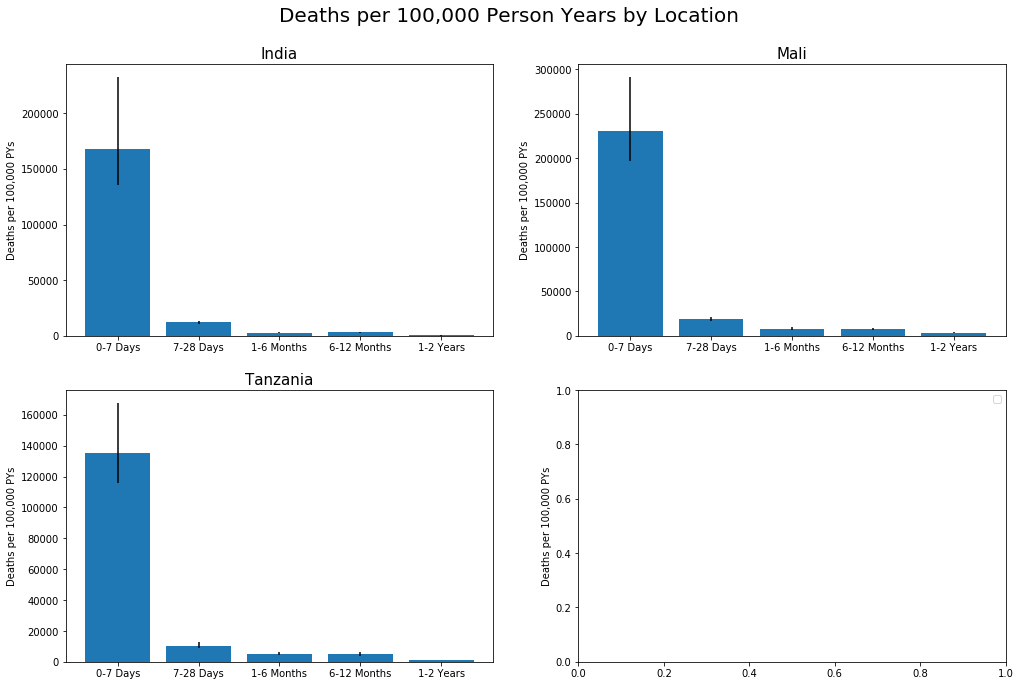

In [77]:
data = master_results.where(master_results['malnourishment_category'] == 'overall').dropna()
data['order'] = np.where(data['age_group'] == 'early_neonatal', 1, 0)
data['order'] = np.where(data['age_group'] == 'late_neonatal', 2, data['order'])
data['order'] = np.where(data['age_group'] == '1mo_to_6mo', 3, data['order'])
data['order'] = np.where(data['age_group'] == '6mo_to_1', 4, data['order'])
data['order'] = np.where(data['age_group'] == '1_to_4', 5, data['order'])
data['order'] = np.where(data['age_group'] == 'all', 6, data['order'])
data = data.sort_values(by='order')

ages = ['0-7 Days','7-28 Days','1-6 Months','6-12 Months','1-2 Years']

fig, axs = plt.subplots(2,2)

upper = data['deaths_upper'].where(data['location'] == 'India').dropna() - data['deaths_mean'].where(data['location'] == 'India').dropna()
lower = data['deaths_mean'].where(data['location'] == 'India').dropna() - data['deaths_lower'].where(data['location'] == 'India').dropna()
error =[lower,upper]
axs[0,0].bar(ages,
       data['deaths_mean'].where(data['location'] == 'India').dropna(),
            yerr = error)
axs[0,0].set_title('India',fontsize=15)
#axs[0,0].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['location'] == 'Mali').dropna() - data['deaths_mean'].where(data['location'] == 'Mali').dropna()
lower = data['deaths_mean'].where(data['location'] == 'Mali').dropna() - data['deaths_lower'].where(data['location'] == 'Mali').dropna()
error =[lower,upper]
axs[0,1].bar(ages,
       data['deaths_mean'].where(data['location'] == 'Mali').dropna(),  yerr = error)
axs[0,1].set_title('Mali',fontsize=15)
#axs[0,1].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['location'] == 'Tanzania').dropna() - data['deaths_mean'].where(data['location'] == 'Tanzania').dropna()
lower = data['deaths_mean'].where(data['location'] == 'Tanzania').dropna() - data['deaths_lower'].where(data['location'] == 'Tanzania').dropna()
error =[lower,upper]
axs[1,0].bar(ages,
       data['deaths_mean'].where(data['location'] == 'Tanzania').dropna(),  yerr = error)
axs[1,0].set_title('Tanzania',fontsize=15)
#axs[1,0].set_ylim([0,300_000])


for ax in axs.flat:
    ax.set(ylabel='Deaths per 100,000 PYs')
    
plt.legend(['Baseline'])
plt.subplots_adjust(right=2.3, top=2.2)
fig.suptitle('Deaths per 100,000 Person Years by Location',x=1.15,y=2.4,fontsize=20)

Text(1, 2.4, 'Deaths per 100,000 Person Years by Age')

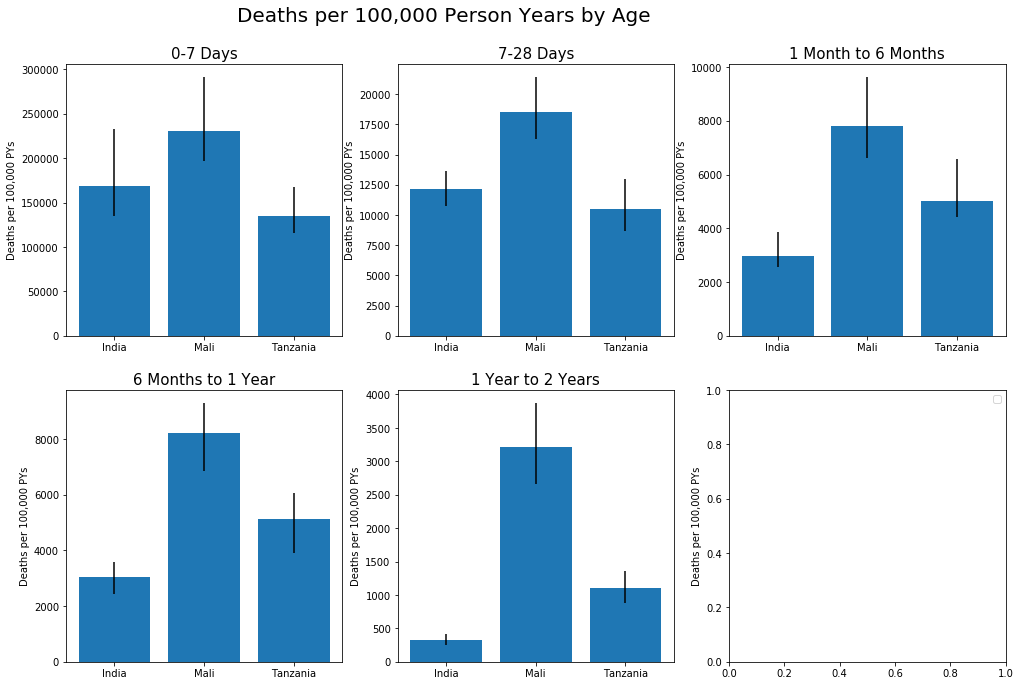

In [70]:
data = master_results.where(master_results['malnourishment_category'] == 'overall').dropna()

fig, axs = plt.subplots(2,3)

upper = data['deaths_upper'].where(data['age_group'] == 'early_neonatal').dropna() - data['deaths_mean'].where(data['age_group'] == 'early_neonatal').dropna()
lower = data['deaths_mean'].where(data['age_group'] == 'early_neonatal').dropna() - data['deaths_lower'].where(data['age_group'] == 'early_neonatal').dropna()
error =[lower,upper]
axs[0,0].bar(data['location'].where(data['age_group'] == 'early_neonatal').dropna(),
       data['deaths_mean'].where(data['age_group'] == 'early_neonatal').dropna(),
            yerr = error)
axs[0,0].set_title('0-7 Days',fontsize=15)
#axs[0,0].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['age_group'] == 'late_neonatal').dropna() - data['deaths_mean'].where(data['age_group'] == 'late_neonatal').dropna()
lower = data['deaths_mean'].where(data['age_group'] == 'late_neonatal').dropna() - data['deaths_lower'].where(data['age_group'] == 'late_neonatal').dropna()
error =[lower,upper]
axs[0,1].bar(data['location'].where(data['age_group'] == 'late_neonatal').dropna(),
       data['deaths_mean'].where(data['age_group'] == 'late_neonatal').dropna(),  yerr = error)
axs[0,1].set_title('7-28 Days',fontsize=15)
#axs[0,1].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['age_group'] == '1mo_to_6mo').dropna() - data['deaths_mean'].where(data['age_group'] == '1mo_to_6mo').dropna()
lower = data['deaths_mean'].where(data['age_group'] == '1mo_to_6mo').dropna() - data['deaths_lower'].where(data['age_group'] == '1mo_to_6mo').dropna()
error =[lower,upper]
axs[0,2].bar(data['location'].where(data['age_group'] == '1mo_to_6mo').dropna(),
       data['deaths_mean'].where(data['age_group'] == '1mo_to_6mo').dropna(),  yerr = error)
axs[0,2].set_title('1 Month to 6 Months',fontsize=15)
#axs[0,2].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['age_group'] == '6mo_to_1').dropna() - data['deaths_mean'].where(data['age_group'] == '6mo_to_1').dropna()
lower = data['deaths_mean'].where(data['age_group'] == '6mo_to_1').dropna() - data['deaths_lower'].where(data['age_group'] == '6mo_to_1').dropna()
error =[lower,upper]
axs[1,0].bar(data['location'].where(data['age_group'] == '6mo_to_1').dropna(),
       data['deaths_mean'].where(data['age_group'] == '6mo_to_1').dropna(),  yerr = error)
axs[1,0].set_title('6 Months to 1 Year',fontsize=15)
#axs[1,0].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['age_group'] == '1_to_4').dropna() - data['deaths_mean'].where(data['age_group'] == '1_to_4').dropna()
lower = data['deaths_mean'].where(data['age_group'] == '1_to_4').dropna() - data['deaths_lower'].where(data['age_group'] == '1_to_4').dropna()
error =[lower,upper]
axs[1,1].bar(data['location'].where(data['age_group'] == '1_to_4').dropna(),
       data['deaths_mean'].where(data['age_group'] == '1_to_4').dropna(),  yerr = error)
axs[1,1].set_title('1 Year to 2 Years',fontsize=15)
#axs[1,1].set_ylim([0,300_000])

for ax in axs.flat:
    ax.set(ylabel='Deaths per 100,000 PYs')
    
plt.legend(['Baseline'])
plt.subplots_adjust(right=2.3, top=2.2)
fig.suptitle('Deaths per 100,000 Person Years by Age',x=1,y=2.4,fontsize=20)

Text(1.15, 2.4, 'Deaths per 100,000 Person Years by Location')

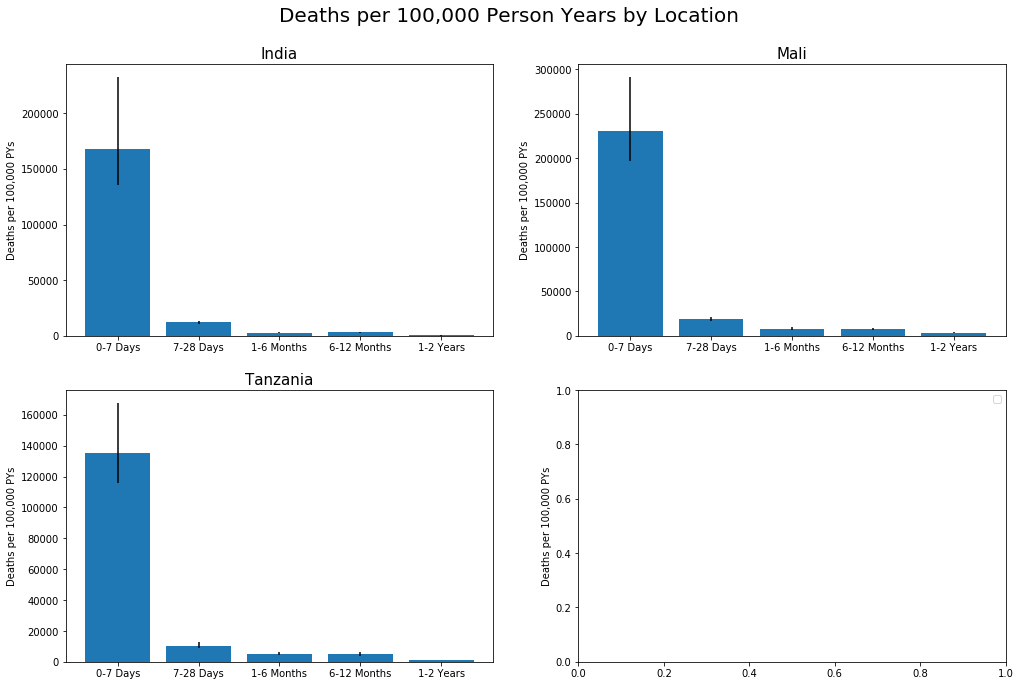

In [78]:
data = master_results.where(master_results['malnourishment_category'] == 'overall').dropna()
data['order'] = np.where(data['age_group'] == 'early_neonatal', 1, 0)
data['order'] = np.where(data['age_group'] == 'late_neonatal', 2, data['order'])
data['order'] = np.where(data['age_group'] == '1mo_to_6mo', 3, data['order'])
data['order'] = np.where(data['age_group'] == '6mo_to_1', 4, data['order'])
data['order'] = np.where(data['age_group'] == '1_to_4', 5, data['order'])
data['order'] = np.where(data['age_group'] == 'all', 6, data['order'])
data = data.sort_values(by='order')

ages = ['0-7 Days','7-28 Days','1-6 Months','6-12 Months','1-2 Years']

fig, axs = plt.subplots(2,2)

upper = data['deaths_upper'].where(data['location'] == 'India').dropna() - data['deaths_mean'].where(data['location'] == 'India').dropna()
lower = data['deaths_mean'].where(data['location'] == 'India').dropna() - data['deaths_lower'].where(data['location'] == 'India').dropna()
error =[lower,upper]
axs[0,0].bar(ages,
       data['deaths_mean'].where(data['location'] == 'India').dropna(),
            yerr = error)
axs[0,0].set_title('India',fontsize=15)
#axs[0,0].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['location'] == 'Mali').dropna() - data['deaths_mean'].where(data['location'] == 'Mali').dropna()
lower = data['deaths_mean'].where(data['location'] == 'Mali').dropna() - data['deaths_lower'].where(data['location'] == 'Mali').dropna()
error =[lower,upper]
axs[0,1].bar(ages,
       data['deaths_mean'].where(data['location'] == 'Mali').dropna(),  yerr = error)
axs[0,1].set_title('Mali',fontsize=15)
#axs[0,1].set_ylim([0,300_000])

upper = data['deaths_upper'].where(data['location'] == 'Tanzania').dropna() - data['deaths_mean'].where(data['location'] == 'Tanzania').dropna()
lower = data['deaths_mean'].where(data['location'] == 'Tanzania').dropna() - data['deaths_lower'].where(data['location'] == 'Tanzania').dropna()
error =[lower,upper]
axs[1,0].bar(ages,
       data['deaths_mean'].where(data['location'] == 'Tanzania').dropna(),  yerr = error)
axs[1,0].set_title('Tanzania',fontsize=15)
#axs[1,0].set_ylim([0,300_000])


for ax in axs.flat:
    ax.set(ylabel='Deaths per 100,000 PYs')
    
plt.legend(['Baseline'])
plt.subplots_adjust(right=2.3, top=2.2)
fig.suptitle('Deaths per 100,000 Person Years by Location',x=1.15,y=2.4,fontsize=20)

Text(1.15, 2.4, 'DALYs per 100,000 Person Years by Location')

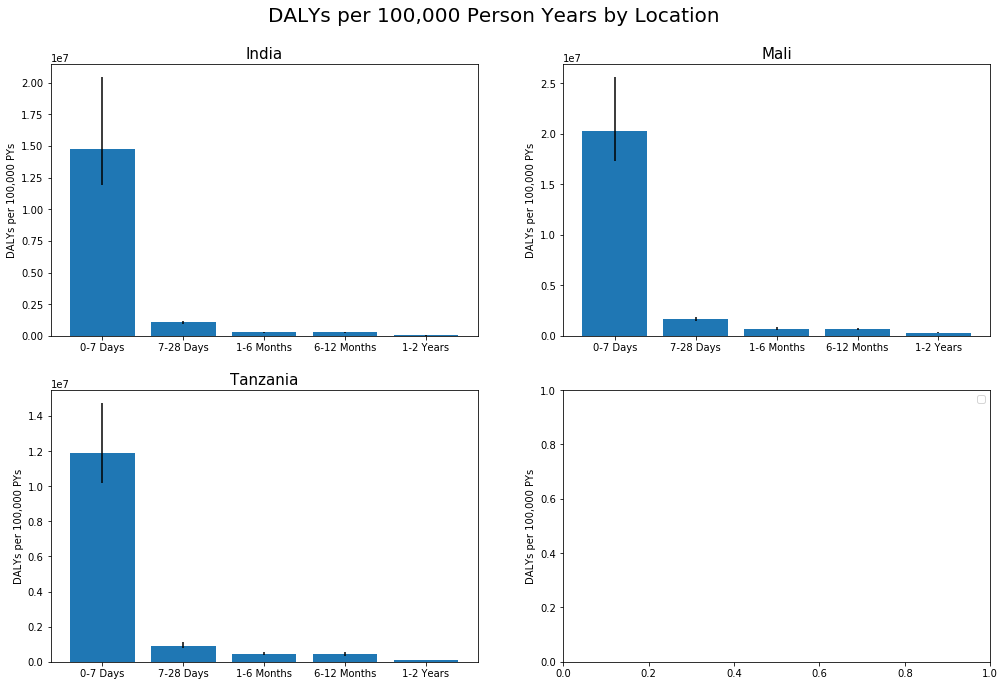

In [79]:
data = master_results.where(master_results['malnourishment_category'] == 'overall').dropna()
data['order'] = np.where(data['age_group'] == 'early_neonatal', 1, 0)
data['order'] = np.where(data['age_group'] == 'late_neonatal', 2, data['order'])
data['order'] = np.where(data['age_group'] == '1mo_to_6mo', 3, data['order'])
data['order'] = np.where(data['age_group'] == '6mo_to_1', 4, data['order'])
data['order'] = np.where(data['age_group'] == '1_to_4', 5, data['order'])
data['order'] = np.where(data['age_group'] == 'all', 6, data['order'])
data = data.sort_values(by='order')

ages = ['0-7 Days','7-28 Days','1-6 Months','6-12 Months','1-2 Years']

fig, axs = plt.subplots(2,2)

upper = data['dalys_upper'].where(data['location'] == 'India').dropna() - data['dalys_mean'].where(data['location'] == 'India').dropna()
lower = data['dalys_mean'].where(data['location'] == 'India').dropna() - data['dalys_lower'].where(data['location'] == 'India').dropna()
error =[lower,upper]
axs[0,0].bar(ages,
       data['dalys_mean'].where(data['location'] == 'India').dropna(),
            yerr = error)
axs[0,0].set_title('India',fontsize=15)
#axs[0,0].set_ylim([0,300_000])

upper = data['dalys_upper'].where(data['location'] == 'Mali').dropna() - data['dalys_mean'].where(data['location'] == 'Mali').dropna()
lower = data['dalys_mean'].where(data['location'] == 'Mali').dropna() - data['dalys_lower'].where(data['location'] == 'Mali').dropna()
error =[lower,upper]
axs[0,1].bar(ages,
       data['dalys_mean'].where(data['location'] == 'Mali').dropna(),  yerr = error)
axs[0,1].set_title('Mali',fontsize=15)
#axs[0,1].set_ylim([0,300_000])

upper = data['dalys_upper'].where(data['location'] == 'Tanzania').dropna() - data['dalys_mean'].where(data['location'] == 'Tanzania').dropna()
lower = data['dalys_mean'].where(data['location'] == 'Tanzania').dropna() - data['dalys_lower'].where(data['location'] == 'Tanzania').dropna()
error =[lower,upper]
axs[1,0].bar(ages,
       data['dalys_mean'].where(data['location'] == 'Tanzania').dropna(),  yerr = error)
axs[1,0].set_title('Tanzania',fontsize=15)
#axs[1,0].set_ylim([0,300_000])


for ax in axs.flat:
    ax.set(ylabel='DALYs per 100,000 PYs')
    
plt.legend(['Baseline'])
plt.subplots_adjust(right=2.3, top=2.2)
fig.suptitle('DALYs per 100,000 Person Years by Location',x=1.15,y=2.4,fontsize=20)

Text(1.5, 2.4, 'Dalys per 100,000 Person Years by Age')

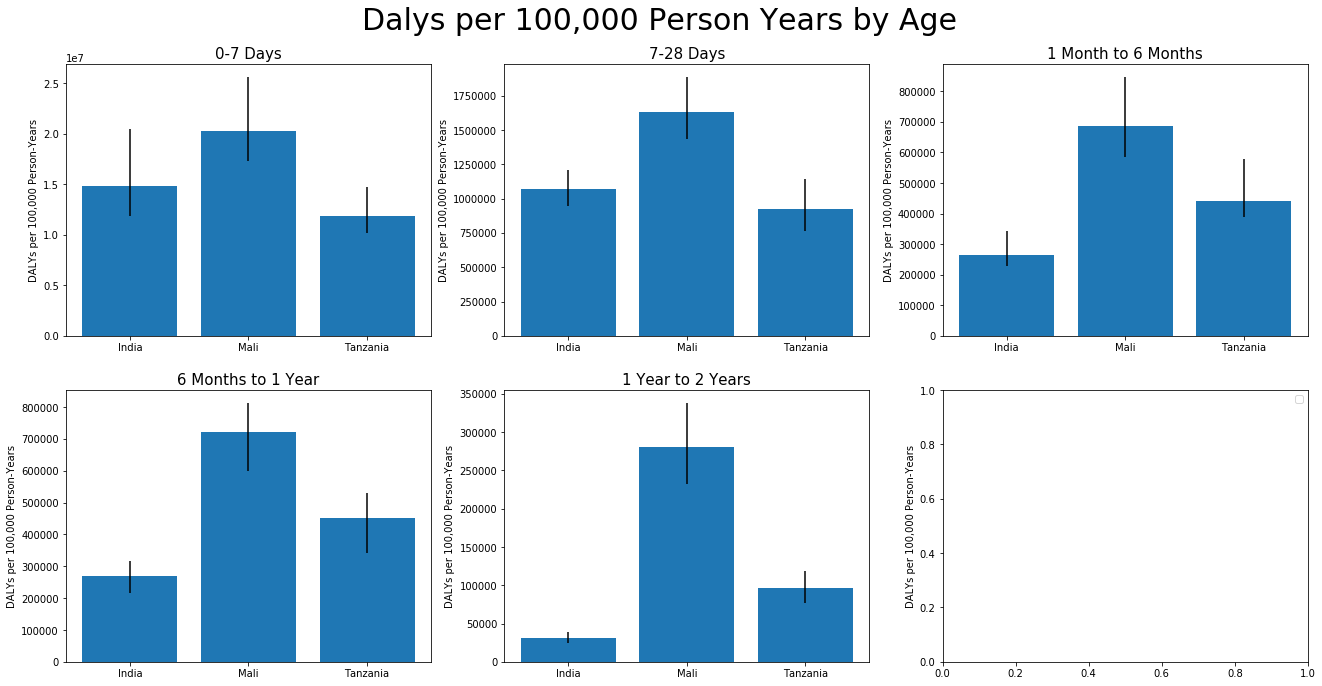

In [80]:
data = master_results.where(master_results['malnourishment_category'] == 'overall').dropna()

fig, axs = plt.subplots(2,3)

upper = data['dalys_upper'].where(data['age_group'] == 'early_neonatal').dropna() - data['dalys_mean'].where(data['age_group'] == 'early_neonatal').dropna()
lower = data['dalys_mean'].where(data['age_group'] == 'early_neonatal').dropna() - data['dalys_lower'].where(data['age_group'] == 'early_neonatal').dropna()
error =[lower,upper]
axs[0,0].bar(data['location'].where(data['age_group'] == 'early_neonatal').dropna(),
       data['dalys_mean'].where(data['age_group'] == 'early_neonatal').dropna(),
            yerr = error)
axs[0,0].set_title('0-7 Days',fontsize=15)
#axs[0,0].set_ylim([0,10_000_000])

upper2 = data['dalys_upper'].where(data['age_group'] == 'late_neonatal').dropna() - data['dalys_mean'].where(data['age_group'] == 'late_neonatal').dropna()
lower2 = data['dalys_mean'].where(data['age_group'] == 'late_neonatal').dropna() - data['dalys_lower'].where(data['age_group'] == 'late_neonatal').dropna()
error2 =[lower2,upper2]
axs[0,1].bar(data['location'].where(data['age_group'] == 'late_neonatal').dropna(),
       data['dalys_mean'].where(data['age_group'] == 'late_neonatal').dropna(), yerr=error2)
axs[0,1].set_title('7-28 Days',fontsize=15)
#axs[0,1].set_ylim([0,10_000_000])

upper = data['dalys_upper'].where(data['age_group'] == '1mo_to_6mo').dropna() - data['dalys_mean'].where(data['age_group'] == '1mo_to_6mo').dropna()
lower = data['dalys_mean'].where(data['age_group'] == '1mo_to_6mo').dropna() - data['dalys_lower'].where(data['age_group'] == '1mo_to_6mo').dropna()
error =[lower,upper]
axs[0,2].bar(data['location'].where(data['age_group'] == '1mo_to_6mo').dropna(),
       data['dalys_mean'].where(data['age_group'] == '1mo_to_6mo').dropna(),  yerr = error)
axs[0,2].set_title('1 Month to 6 Months',fontsize=15)
#axs[0,2].set_ylim([0,10_000_000])

upper = data['dalys_upper'].where(data['age_group'] == '6mo_to_1').dropna() - data['dalys_mean'].where(data['age_group'] == '6mo_to_1').dropna()
lower = data['dalys_mean'].where(data['age_group'] == '6mo_to_1').dropna() - data['dalys_lower'].where(data['age_group'] == '6mo_to_1').dropna()
error =[lower,upper]
axs[1,0].bar(data['location'].where(data['age_group'] == '6mo_to_1').dropna(),
       data['dalys_mean'].where(data['age_group'] == '6mo_to_1').dropna(),  yerr = error)
axs[1,0].set_title('6 Months to 1 Year',fontsize=15)
#axs[1,0].set_ylim([0,10_000_000])

upper = data['dalys_upper'].where(data['age_group'] == '1_to_4').dropna() - data['dalys_mean'].where(data['age_group'] == '1_to_4').dropna()
lower = data['dalys_mean'].where(data['age_group'] == '1_to_4').dropna() - data['dalys_lower'].where(data['age_group'] == '1_to_4').dropna()
error =[lower,upper]
axs[1,1].bar(data['location'].where(data['age_group'] == '1_to_4').dropna(),
       data['dalys_mean'].where(data['age_group'] == '1_to_4').dropna(),  yerr = error)
axs[1,1].set_title('1 Year to 2 Years',fontsize=15)
#axs[1,1].set_ylim([0,10_000_00000])

for ax in axs.flat:
    ax.set(ylabel='DALYs per 100,000 Person-Years')
    
plt.legend(['Baseline'])
plt.subplots_adjust(right=3, top=2.2)
fig.suptitle('Dalys per 100,000 Person Years by Age',x=1.5,y=2.4,fontsize=30)